In [1]:
import torchvision
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import tqdm

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
                               # transforms.Normalize(mean=[0.5],std=[0.5])])

data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 128,
                                                shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 128,
                                               shuffle = False)

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hid_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hid_dim, latent_dim)
        self.log_var = nn.Linear(hid_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        std = torch.exp(log_var / 2)
        z = torch.randn_like(mu) * std + mu
        recon_x = self.decoder(z)
        return recon_x, mu, log_var
    
    def generate(self, z):
        return self.decoder(z)

    
def kl_loss(mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp()) 
    return kl_loss

def mse_loss(x, recon_x):
    return ((x - recon_x) ** 2).sum()

In [7]:
model = VAE(784, 512, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 5
for ep in range(epochs):
    for x, y in tqdm.tqdm(train_loader):
        x = x.reshape(-1, 784)
        recon_x, mu, log_var = model(x)
        mse = mse_loss(x, recon_x)
        kl = kl_loss(mu, log_var)
        loss = mse + kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
z1, z2 = torch.linspace(-5, 5, 10), torch.linspace(-5, 5, 10)
z1_grid, z2_grid = torch.meshgrid(z1, z2)
zspace = torch.stack([z1_grid.reshape(-1), z2_grid.reshape(-1)]).T

In [15]:
samples = model.generate(zspace)

In [16]:
sample_img = torchvision.utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=10)

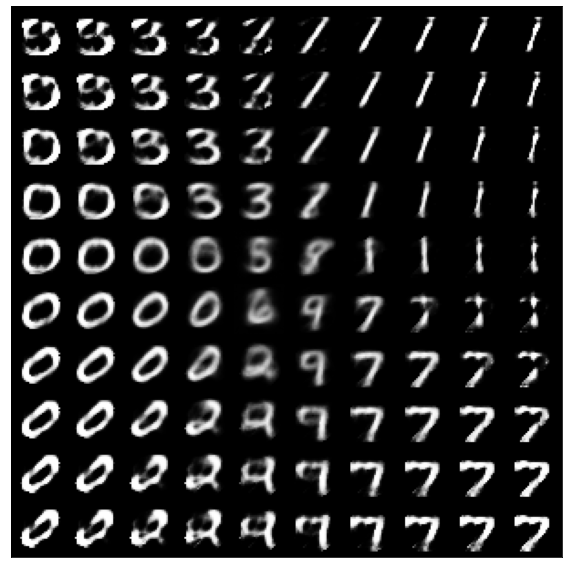

In [18]:
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(sample_img.permute(1, 2, 0))
plt.tight_layout()